# Discrete Signals
This document explores how the approach of automatic differentiation generalizes to the case of discrete signals.
E.g. if the density is provided as a profile sampled on a discrete grid.

**Problem**

To use auto-grad approach, we need to translate the discrete density-signal to a *differentiable* function of elementary operations ($*, +, -, \sin, \cos, ...$).

**Idea 1 (semi-tested below)**

My first naíve idea was to interpolate the signal to obtain an analytical representation from this. However
- "nearest" interpolation is not differentiable
- "linear" interpolation with scipy doesn't work and is also not differentiable (it's only piecewise linear).
- Pytorch' interpolation implementation just "spits out" a new discrete signal instead of the analytical function form which we need. So I'm quite sure this is unusable for auto-grad.

**Idea 2**

Represent the signal as a Fourier Decomposition (shannon sampling thm).

**Idea 3**

Not implemented yet: Represent signal as neural network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import matplotlib as mpl
from scipy.integrate import solve_ivp
import torch

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

## 1D Signal

Consider a discretely sampled signal.

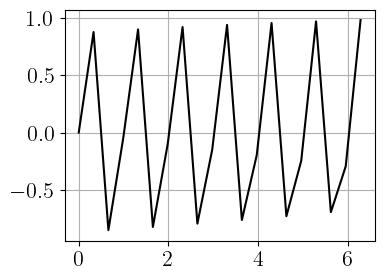

In [3]:
f = 1
x = np.linspace(0,2*np.pi,20)
y = np.sin(2*np.pi*f*x)

plt.figure(figsize=(4,3))
plt.plot(x,y, '-k')
plt.grid()
plt.show()

The discrete signal is represented by its' Fourier decomposition,
which we can then differentiate.

In [4]:
def fit_signal(x, y, mode='fft'):
    if mode=='fft':
        import torch.fft as fft

        freqs = fft.fftfreq(y.shape[-1], np.diff(x.detach().numpy())[0]).detach()
        y_fft = fft.fft(y).detach()
        N = len(y)

        def fit(x0):
            return 1/N*torch.real(torch.matmul(y_fft.cfloat(), torch.exp(1j*2*np.pi*freqs*x0).cfloat()))
            
        def fit_vectorized(x):
            return 1/N*torch.real(torch.matmul(y_fft.cfloat(), torch.exp(1j*2*np.pi*torch.outer(freqs, torch.atleast_1d(x))).cfloat()))
        
        return fit, fit_vectorized

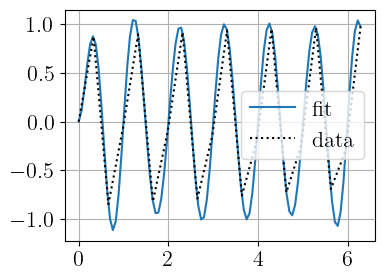

In [5]:
x_T = torch.tensor(x)
y_T = torch.tensor(y)
fit, fit_vectorized = fit_signal(x_T, y_T)

x_s = torch.linspace(x.min(), x.max(),100)

plt.figure(figsize=(4,3))
plt.plot(x_s, fit_vectorized(x_s), '-', color='tab:blue', label='fit')
plt.plot(x_T, y_T, ':k', label='data')
plt.legend()
plt.grid()
plt.show()

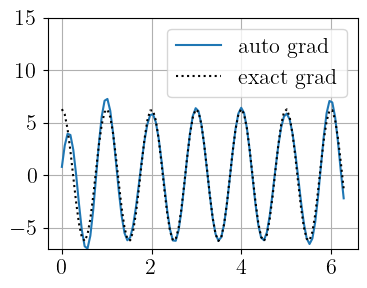

In [6]:
# Derivative at single point
x0 = torch.tensor([5.0], requires_grad=True)
y_s = fit(x0)
y_s.backward()
x0.grad

# Create tensor of derivative values
x_s = torch.linspace(x.min(), x.max(),100)
dydx = torch.zeros_like(x_s)
for i, x_s_i in enumerate(x_s):
    x_i = x_s_i.detach().requires_grad_(True)
    y_i = fit(x_i)
    y_i.backward()
    dydx[i] = x_i.grad

plt.figure(figsize=(4,3))
plt.plot(x_s, dydx, label='auto grad')
plt.plot(x_s, 2*np.pi*f*np.cos(2*np.pi*f*x_s), ':k', label='exact grad')
plt.ylim(-7,15)
plt.legend()
plt.grid()
plt.show()

## 2D Signal

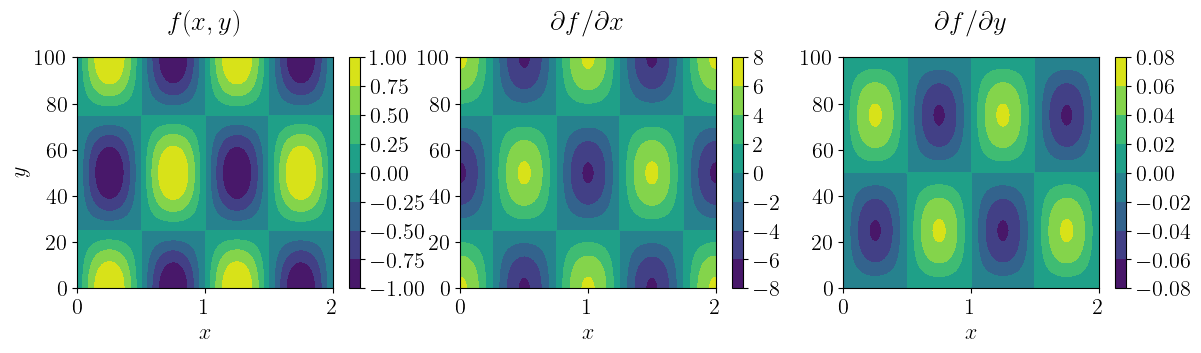

In [7]:
fx = 1
fy = 0.01
x = np.linspace(0,2,200)
y = np.linspace(0,100,200)

x_m, y_m = np.meshgrid(x, y)
N_y, N_x = x_m.shape
z_m = np.sin(2*np.pi*fx*x_m)*np.cos(2*np.pi*fy*y_m)
dzdx_m = 2*np.pi*fx*np.cos(2*np.pi*fx*x_m)*np.cos(2*np.pi*fy*y_m)
dzdy_m = -2*np.pi*fy*np.sin(2*np.pi*fx*x_m)*np.sin(2*np.pi*fy*y_m)
# z_m = np.sin(2*np.pi*fx*x_m)*y_m
# dzdx_m = 2*np.pi*fx*np.cos(2*np.pi*fx*x_m)*y_m
# dzdy_m = np.sin(2*np.pi*fx*x_m)

figs, axs = plt.subplots(1,3, figsize=(14,3))
im0 = axs[0].contourf(x_m, y_m, z_m)
axs[0].set_title('$f(x,y)$')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
plt.colorbar(im0)
im1 = axs[1].contourf(x_m, y_m, dzdx_m)
axs[1].set_title('$\partial f/\partial x$')
axs[1].set_xlabel('$x$')
plt.colorbar(im1)
im2 = axs[2].contourf(x_m, y_m, dzdy_m)
axs[2].set_title('$\partial f/\partial y$')
axs[2].set_xlabel('$x$')
plt.colorbar(im2)
plt.show()

### With Neural Network

In [ ]:
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self,
        N_in, N_out,
        N_hid = 30, N_layers=3,
        loss_func=nn.MSELoss(),
        learning_rate = 0.005,
        optimizer = optim.Adam,
        act_func=nn.Tanh()
                ):
        
        super(Net, self).__init__()
        self.loss_func = loss_func

        # Initialise layers
        layers = [nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True), act_func]
        for _ in range(N_layers - 1):
            layers += [nn.Linear(in_features=N_hid,
                    out_features=N_hid,
                    bias=True), act_func]
        layers += [nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)]

        self.layers = nn.Sequential(*layers)
        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        
        # Save hyperparameters
        self.N_hid = N_hid
        self.N_layers = N_layers
        self.act_func = act_func
        self.learning_rate = learning_rate
        self.N_params = sum([p.numel() for p in self.parameters()])
        
    def forward(self, x, t):
        x = torch.cat((x, t), dim=1)
        out = self.layers(x)
        return out
    
    def MSE(self, data, r, t):
        u = data.detach().reshape(-1,1)
        u_hat = self.forward(x,t).detach().reshape(-1,1)
        MSE = torch.mean((u - u_hat)**2)
        return MSE

    def loss(self, data, x, t):
        return MSE()
    
    def step(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        self.train()
        self.optimizer.zero_grad()
        loss, loss_PDE, loss_IC, loss_BC = self.loss(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return loss.detach().item()

### With Fourier Decomposition

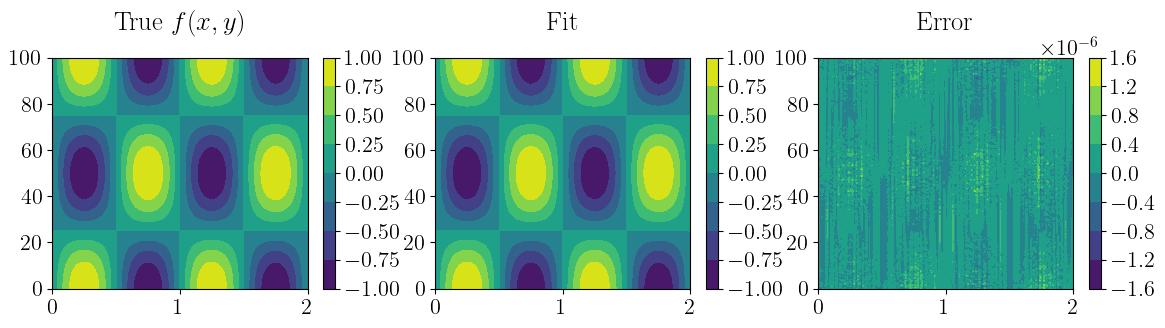

In [10]:
def fit_signal_2D(x_mesh, y_mesh, z, mode='fft'):
    if mode=='fft':
        import torch.fft as fft

        N_y, N_x = z.shape
        # print('N_x', N_x)
        # print('N_y', N_y)
        d_x = torch.diff(x_T)[0,0]
        d_y = torch.diff(y_T, dim=0)[0,0]
        freqs_x = fft.fftfreq(N_x, d_x).detach()
        freqs_y = fft.fftfreq(N_y, d_y).detach()
        fft2 = fft.fft2(z).detach()

        def fit(x0, y0):
            # x0, y0 = r
            exp_x = torch.exp(1j*2*np.pi*x0*freqs_x).cfloat()
            exp_y = torch.exp(1j*2*np.pi*freqs_y*y0).cfloat()
            return 1/N_x*1/N_y*torch.real(torch.matmul(exp_y, torch.matmul(fft2.cfloat(), exp_x)))
        
        def fit_vectorized(x, y):
            x_1D = x[0,:]
            y_1D = y[:,0]
            exp_x = torch.exp(1j*2*np.pi*torch.outer(freqs_x, x_1D)).cfloat()
            exp_y = torch.exp(1j*2*np.pi*torch.outer(y_1D, freqs_y)).cfloat()
            # print('x_1D.shape', x_1D.shape)
            # print('y_1D.shape', y_1D.shape)
            # print('freqs_x.shape', freqs_x.shape)
            # print('freqs_y.shape', freqs_y.shape)
            # print('fft2.cfloat().shape', fft2.cfloat().shape)
            # print('exp_x.shape', exp_x.shape)
            # print('exp_y.shape', exp_y.shape)
            return 1/N_x*1/N_y*torch.real(torch.matmul(exp_y, torch.matmul(fft2.cfloat(), exp_x)))
        
        return fit, fit_vectorized

x_T = torch.tensor(x_m)
y_T = torch.tensor(y_m)
z_T = torch.tensor(z_m)
fit, fit_vectorized = fit_signal_2D(x_T, y_T, z_T)
fit_vectorized(x_T, y_T).shape, z_m.shape
z_fit = fit_vectorized(x_T, y_T)

figs, axs = plt.subplots(1,3, figsize=(14,3))
im0 = axs[0].contourf(x_T, y_T, z_T)
plt.colorbar(im0)
axs[0].set_title('True $f(x,y)$')
im1 = axs[1].contourf(x_T, y_T, z_fit)
axs[1].set_title('Fit')
plt.colorbar(im1)
im2 = axs[2].contourf(x_T, y_T, z_fit - z_T)
axs[2].set_title('Error')
plt.colorbar(im2)
plt.show()

In [11]:
# # Attempt at backward prop on vector data
# X, Y = x_T.detach().requires_grad_(), y_T.detach().requires_grad_()
# Z_fit = fit_vectorized(X, Y)
# Z_fit.backward(torch.ones_like(X))

# figs, axs = plt.subplots(1,2, figsize=(9,3))

# im0 = axs[0].contourf(x_T, y_T, dzdx_T)
# axs[0].set_title('true $\partial z/\partial x$')
# plt.colorbar(im0)

# im1 = axs[1].contourf(x_T, y_T, X.grad)
# axs[1].set_title('auto $\partial z/\partial x$')
# plt.colorbar(im1)
# plt.show()


In [12]:
fit_v_man = torch.zeros_like(x_T)
if x_T.shape[0] <= 250:
    for i_x in range(N_x):
        for i_y in range(N_y):
            # r_i = torch.hstack((x_T[i_x, i_y], y_T[i_x, i_y])).detach()
            x0, y0 = x_T[i_y, i_x], y_T[i_y, i_x]
            fit_v_man[i_y, i_x] = fit(x0, y0)

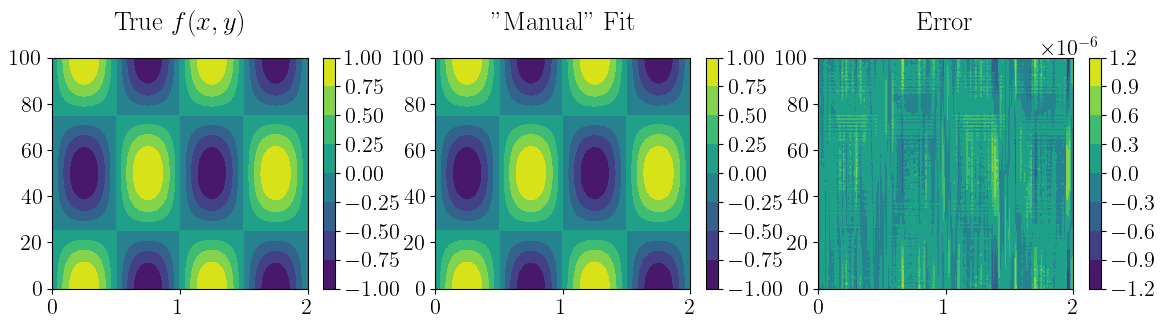

In [13]:
figs, axs = plt.subplots(1,3, figsize=(14,3))
im0 = axs[0].contourf(x_T, y_T, z_T)
plt.colorbar(im0)
axs[0].set_title('True $f(x,y)$')
im1 = axs[1].contourf(x_T, y_T, fit_v_man)
axs[1].set_title('"Manual" Fit')
plt.colorbar(im1)
im2 = axs[2].contourf(x_T, y_T, fit_v_man - z_T)
axs[2].set_title('Error')
plt.colorbar(im2)
plt.show()

In [14]:
# # Derivative at single point
# # r0 = torch.tensor([2.5, 2.5], requires_grad=True)
# x0, y0 = torch.tensor([torch.pi/4], requires_grad=True), torch.tensor([2.5], requires_grad=True)
# x0, y0 = torch.tensor([5.0], requires_grad=True), torch.tensor([2.5], requires_grad=True)
# z_s = fit(x0, y0)
# z0 = torch.sin(2*torch.pi*fx*x0)*torch.cos(2*torch.pi*fy*y0)
# print(z_s, z0)

# z_s.backward()
# print('auto grad')
# print(x0.grad, y0.grad)

# dzdx0 = (2*torch.pi*fx*torch.cos(2*np.pi*fx*x0)*torch.cos(2*np.pi*fy*y0)).detach()
# dzdy0 = (-2*torch.pi*fy*torch.sin(2*np.pi*fx*x0)*torch.sin(2*np.pi*fy*y0)).detach()
# print('exact grad')
# print(dzdx0, dzdy0)


# Create tensor of derivative values
dzdx_T = torch.tensor(dzdx_m)
dzdy_T = torch.tensor(dzdy_m)

dzdx = torch.zeros_like(x_T)
dzdy = torch.zeros_like(x_T)
# r_s = torch.zeros_like(x_s_m)

for i_x in range(N_x):
    for i_y in range(N_y):
        x0 = x_T[i_y, i_x].detach().requires_grad_(True)
        y0 = y_T[i_y, i_x].detach().requires_grad_(True)
        # r_i = torch.hstack((x_i, y_i)).detach().requires_grad_(True)
        z0 = fit(x0, y0)
        z0.backward()
        dzdx[i_y, i_x] = x0.grad
        dzdy[i_y, i_x] = y0.grad

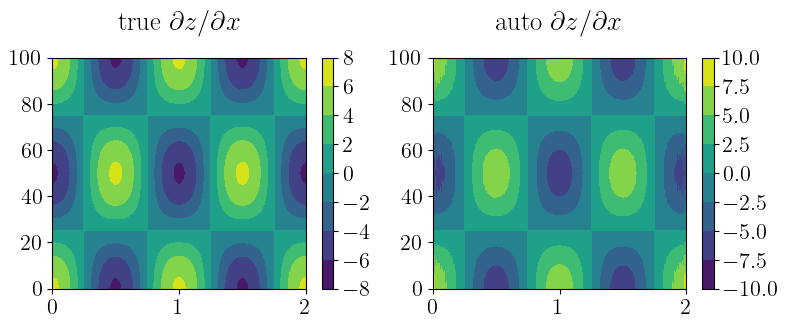

In [15]:
figs, axs = plt.subplots(1,2, figsize=(9,3))

im0 = axs[0].contourf(x_T, y_T, dzdx_T)
axs[0].set_title('true $\partial z/\partial x$')
plt.colorbar(im0)

im1 = axs[1].contourf(x_T, y_T, dzdx)
axs[1].set_title('auto $\partial z/\partial x$')
plt.colorbar(im1)
plt.show()

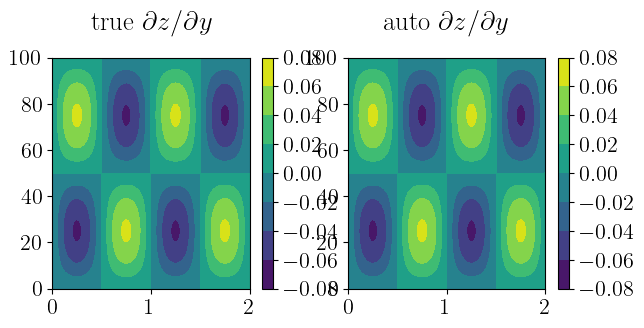

In [16]:
figs, axs = plt.subplots(1,2, figsize=(7,3))

im0 = axs[0].contourf(x_T, y_T, dzdy_T)
# im0.set_clim(vmin=-1, vmax=1)
axs[0].set_title('true $\partial z/\partial y$')
plt.colorbar(im0)

# im1 = axs[1].contourf(x_T[10:-10,10:-10], y_T[10:-10,10:-10], dzdy[10:-10,10:-10])
im1 = axs[1].contourf(x_T, y_T, dzdy)
# im1.set_clim(vmin=-1, vmax=1)
plt.colorbar(im1)
axs[1].set_title('auto $\partial z/\partial y$')
plt.show()

### Experiments

In [74]:
x = torch.tensor([2.0, 4.0], requires_grad=True)
y = torch.tensor([3.0, 1.0], requires_grad=True)
f = 2*x*y
f.backward(torch.ones_like(x))
x.grad, y.grad
# f = torch.tensor([x*y, x/y])
# f.backward(torch.ones_like(x))
# x.grad, y.grad

(tensor([6., 2.]), tensor([4., 8.]))

In [138]:
x = torch.tensor([2.0], requires_grad=True)
y = torch.tensor([3.0], requires_grad=True)
f = torch.vstack([2*x*y, x/y])
f[1].backward(torch.ones(1), retain_graph=True)
x.grad, y.grad
# f[0,:].backward(torch.ones_like(x), retain_graph=True)
# x.grad, y.grad

(tensor([0.3333]), tensor([-0.2222]))

In [117]:
x.grad.zero_()
y.grad.zero_()
f[:,0].backward(torch.ones_like(x), retain_graph=True)
x.grad, y.grad

(tensor([6.3333, 0.0000]), tensor([3.7778, 0.0000]))

In [99]:
2*x*y

tensor([12.,  8.], grad_fn=<MulBackward0>)

In [92]:
f

tensor([[12.0000,  8.0000],
        [ 0.6667,  4.0000]], grad_fn=<CatBackward0>)

In [82]:
2*torch.mul(x,y)

tensor([12.,  8.], grad_fn=<MulBackward0>)

In [66]:
torch.ones_like(f.detach())

tensor([1., 1.])

In [63]:
f

tensor([6.0000, 0.6667])

In [71]:
# plt.quiver(x_s_m.flatten(), y_s_m.flatten(), dzdx.flatten(), dzdy.flatten(), angles='xy', scale_units='xy', scale=50)
# plt.show()

In [38]:
torch.hstack((x_T[50,50], y_T[50,50]))
# fit_vectorized(x_T, y_T)[50,50], fit()

tensor([2.5253, 2.5253], dtype=torch.float64)

In [19]:
fit_vectorized(x_T, y_T)

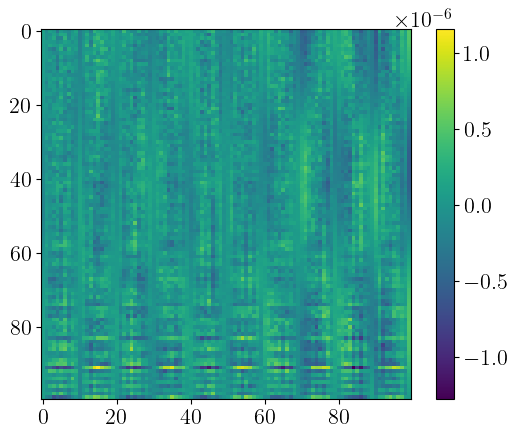

In [11]:
# F = fft.fft(z_T, dim=0)
import torch.fft as fft

x_T = torch.tensor(x_m)
y_T = torch.tensor(y_m)
z_T = torch.tensor(z_m)

xx_T = torch.tensor(x)
yy_T = torch.tensor(y)

d_x = torch.diff(x_T)[0,0]
d_y = torch.diff(y_T, dim=0)[0,0]

N_x, N_y = z_T.shape
freqs_x = fft.fftfreq(z_T.shape[0], d_x).detach()
freqs_y = fft.fftfreq(z_T.shape[1], d_y).detach()
fft2 = fft.fft2(z_T).detach()

exp_x = torch.exp(1j*2*np.pi*torch.outer(xx_T, freqs_x)).cfloat()
exp_y = torch.exp(1j*2*np.pi*torch.outer(freqs_y, yy_T)).cfloat()
z_fit = 1/N_x*1/N_y*torch.real(torch.matmul(exp_x, torch.matmul(fft2.cfloat(), exp_y)))

plt.imshow(z_fit - z_m)
plt.colorbar()

In [125]:
import torch.fft as fft

z_T = torch.tensor(z_m)
z_fft = fft.rfft2(z_T)
# plt.imshow(torch.abs(z_fft))
# torch.abs(fft.rfft2(z_T))

freqs_x = fft.rfftfreq(z_T.shape[0], d=d_x)
freqs_y = fft.rfftfreq(z_T.shape[1], d=d_y)
freqs_x_m, freqs_y_m = np.meshgrid(freqs_x, freqs_y)
# plt.contourf(freqs_x_m, freqs_y_m, z_fft)
freqs_x_m.shape, freqs_y_m.shape, z_fft.shape

((51, 51), (51, 51), torch.Size([100, 51]))

In [144]:
torch.max(torch.imag(z_fit))

tensor(0.2891)

In [139]:
N_x, N_y

(100, 100)

In [131]:
torch.max(z_fit - z_m)

tensor(34.2401, dtype=torch.float64)

In [148]:
# # This cell is working
# # F = fft.fft(z_T, dim=0)

# freqs_x = fft.fftfreq(z_T.shape[0], d_x).detach()
# fft_x = fft.fft(z_T, dim=0).detach()
# N_x = z_T.shape[0]

# z_fit = 1/N_x*torch.real(torch.matmul(torch.exp(1j*2*np.pi*torch.outer(xx_T, freqs_x)).cfloat(), fft_x.cfloat()))

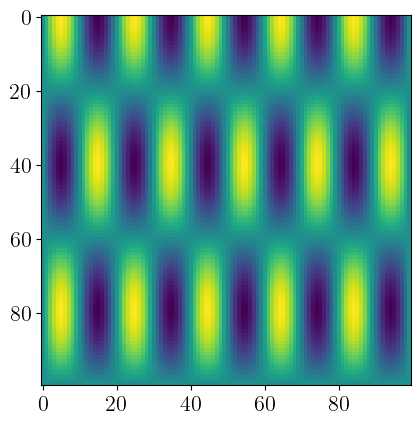

In [179]:
freqs_y = fft.fftfreq(z_T.shape[1], d_y).detach()
fft2 = fft.fft2(z_T).detach()

exp_x = torch.exp(1j*2*np.pi*torch.outer(xx_T, freqs_x)).cfloat()
exp_y = torch.exp(1j*2*np.pi*torch.outer(freqs_y, yy_T)).cfloat()
z_fit = 1/N_x*1/N_y*torch.real(torch.matmul(exp_x, torch.matmul(fft2.cfloat(), exp_y)))

plt.imshow(z_fit)

In [157]:
freqs_y = fft.fftfreq(z_T.shape[1], d_y).detach()
fft_y = fft.fft(z_T, dim=1).detach()
N_y = z_T.shape[1]

z_fit = 1/N_y*torch.real(torch.matmul(fft_y.cfloat(), torch.exp(1j*2*np.pi*torch.outer(freqs_y, yy_T)).cfloat()))

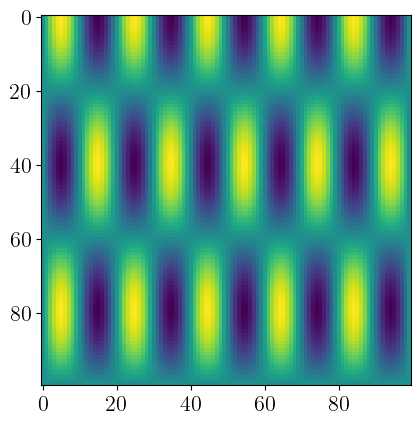

In [178]:
plt.imshow(z_fit)

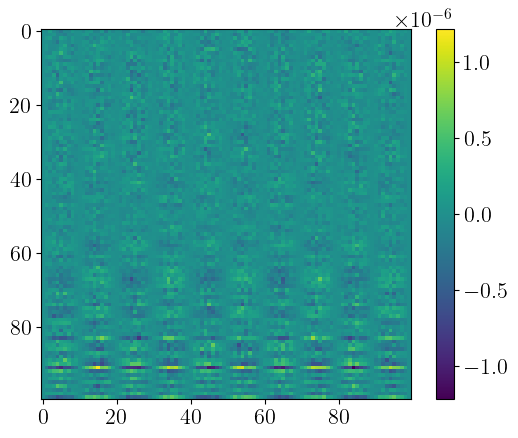

In [121]:
plt.imshow(z_fit - z_T)
plt.colorbar()
plt.show()

In [90]:
fft_x.T.cfloat().shape

torch.Size([100, 100])

In [89]:
torch.exp(1j*2*np.pi*freqs_x*x_T).cfloat().shape

torch.Size([100, 100])

In [ ]:
import torch.fft as fft

freqs = fft.fftfreq(y.shape[-1], np.diff(x.detach().numpy())[0]).detach()
y_fft = fft.fft(y).detach()
N = len(y)

# 1/N*torch.real(torch.matmul(y_fft.cfloat(), torch.exp(1j*2*np.pi*freqs*x).cfloat()))

## Ray Tracer on 2D Density

In [10]:
def n_e(r):
    x, y, z = r
    return torch.sin(x)*torch.cos(y)

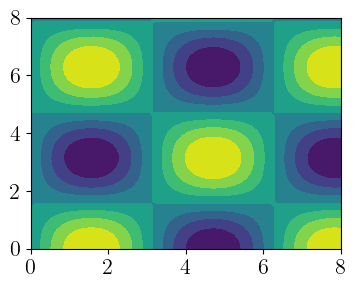

In [17]:
x_plt = np.linspace(0,8)
y_plt = np.linspace(0,8)
X_mesh, Y_mesh = np.meshgrid(x_plt,y_plt)
n_mesh = np.zeros_like(X_mesh)
for i in range(len(x_plt)):
    for j in range(len(y_plt)):
        r_mesh = np.array([X_mesh[i,j], Y_mesh[i, j], 0])
        n_mesh[i, j] = n_e(torch.tensor(r_mesh)).numpy()

plt.figure(figsize=(4,3))
plt.contourf(X_mesh, Y_mesh, n_mesh)
plt.show()

(10, 10, 1) (10, 10, 1) (10, 10, 1) (10, 10, 1)


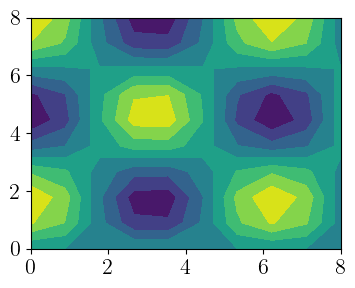

In [19]:
# Sample signal
x_s = np.linspace(0,8,10)
y_s = np.linspace(0,8,10)
z_s = np.array([0.0])
x_m, y_m, z_m = np.meshgrid(x_s, y_s, z_s)
n_m = np.zeros_like(x_m)
for i_x in range(len(x_s)):
    for i_y in range(len(y_s)):
        for i_z in range(len(z_s)):
            r_i = torch.tensor([x_s[i_x], y_s[i_y], z_s[i_z]])
            n_m[i_x, i_y, i_z] = n_e(r_i)
print(x_m.shape, y_m.shape, z_m.shape, n_m.shape)

plt.figure(figsize=(4,3))
plt.contourf(x_m[:,:,0], y_m[:,:,0], n_m[:,:,0])
plt.show()

In [12]:
e = 1.0
eps_0 = 1.0
m_e = 1.0
c = 1.0

def omega_p_squared(r):
    return n_e(r) * e**2 / (eps_0 * m_e)

def X(r, omega):
    return omega_p_squared(r)/(omega**2)

def N(k, omega):
    return c/omega * k

def D(r, k, omega):
    return 1 - X(r, omega) - torch.norm(N(k, omega))**2


In [19]:
def trace_ray(r0, k0, omega0, tmin, tmax, D, r_min=torch.tensor([0, 0, 0]), r_max=torch.tensor([1000,1000,1000])):
    q0 = np.hstack((r0,k0))
    
    def is_in_domain(r):
        ''' Returns 0.0 if ray exceeds boundary'''
        return torch.prod(torch.heaviside(r-r_min, torch.ones_like(r)))*torch.prod(torch.heaviside(r_max-r, torch.ones_like(r)))
    
    # RHS of ray-tracer ODE
    def f(t, q):
        x, y, z, kx, ky, kz = q
        omega = torch.tensor(omega0, requires_grad=True)
        r = torch.tensor([x, y, z], requires_grad=True)
        k = torch.tensor([kx, ky, kz], requires_grad=True)
        
        Di = D(r, k, omega)
        Di.backward()
        grad_r = r.grad
        grad_k = k.grad
        grad_omega = omega.grad
        RHS_r = - grad_k/grad_omega * is_in_domain(r)
        RHS_k = grad_r/grad_omega * is_in_domain(r)
        
        return torch.hstack((RHS_r, RHS_k)).detach().numpy()

    sol = solve_ivp(f, [tmin, tmax], q0, t_eval = np.linspace(tmin,tmax, 100))
    return sol

omega0 1.0
r0 [0. 1. 1.]
k0 [1. 0. 0.]


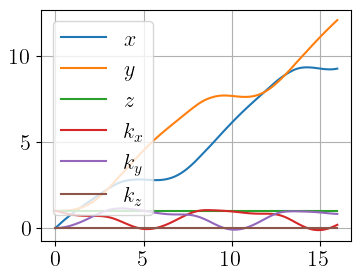

In [20]:
# Ray in x-direction
x0 = 0
omega0 = np.array(1.0)
r0 = np.array([x0,1.0,1.0])
k0 = np.array([np.sqrt(omega0**2*(1-x0)/c**2),0.0,0.0])
print('omega0', omega0)
print('r0', r0)
print('k0', k0)

sol = trace_ray(r0, k0, omega0, tmin=0, tmax=16, D=D)
x, y, z, kx, ky, kz = sol.y

plt.figure(figsize=(4,3))
plt.plot(sol.t, sol.y.T)
plt.legend([r'$x$', r'$y$', r'$z$', r'$k_x$', r'$k_y$', r'$k_z$'])
plt.grid()
plt.show()

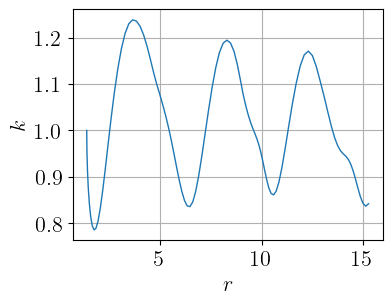

In [21]:
plt.figure(figsize=(4,3))
plt.plot(np.sqrt(x**2+y**2+z**2), np.sqrt(kx**2+ky**2+kz**2), color='tab:blue', linewidth=1)
# plt.xlim(0,1)
# plt.ylim(0,2)
plt.xlabel(r'$r$')
plt.ylabel(r'$k$')
plt.grid()
plt.show()

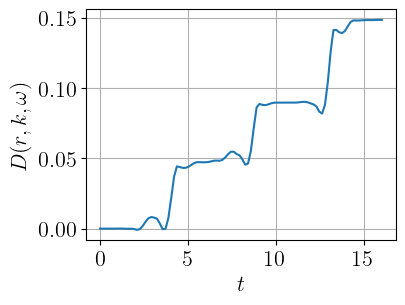

In [23]:
D_v = np.vectorize(D)
rs = sol.y[:3,:]
ks = sol.y[3:,:]
Ds = np.zeros(rs.shape[1])
for i in range(len(rs.T)):
    r = torch.tensor(rs[:,i])
    k = torch.tensor(ks[:,i])
    Ds[i] = D(r, k, omega0)

plt.figure(figsize=(4,3))
plt.plot(sol.t, Ds)
plt.xlabel('$t$')
plt.ylabel('$D(r, k, \omega)$')
plt.grid()
plt.show()

In [24]:
r = torch.tensor([[1.0,0.0], [0.0,1.0], [0.0, 0.0]])
k = torch.tensor([[1.0, 1/np.sqrt(2.0)], [0.0, 1/np.sqrt(2.0)], [0.0, 0.0]])
# print(D(r, k, omega))

r = torch.tensor([1.0, 0.0, 0.0])
k = torch.tensor([1.0, 0.0, 0.0])
D(r, k, 1.0)

tensor(-0.8415)

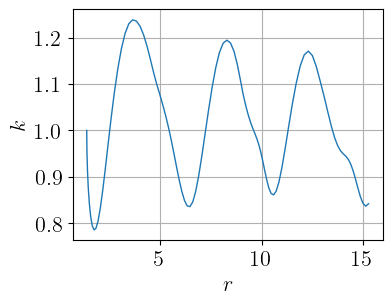

In [25]:
plt.figure(figsize=(4,3))
plt.plot(np.sqrt(x**2+y**2+z**2), np.sqrt(kx**2+ky**2+kz**2), color='tab:blue', linewidth=1)
# plt.xlim(0,1)
# plt.ylim(0,2)
plt.xlabel(r'$r$')
plt.ylabel(r'$k$')
plt.grid()
plt.show()

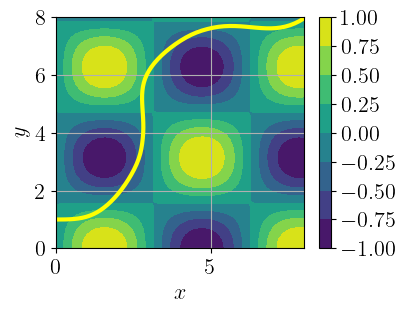

In [26]:
plt.figure(figsize=(4,3))
plt.plot(x,y, color='yellow', linewidth=3)
plt.xlim(0,8)
plt.ylim(0,8)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.contourf(X_mesh, Y_mesh, n_mesh)
plt.colorbar()
plt.grid()
plt.show()

In [27]:
# Sample signal
x_s = np.linspace(0,8,10)
y_s = np.linspace(0,8,10)
z_s = np.array([0.0])
x_m, y_m, z_m = np.meshgrid(x_s, y_s, z_s)
n_m = np.zeros_like(x_m)
for i_x in range(len(x_s)):
    for i_y in range(len(y_s)):
        for i_z in range(len(z_s)):
            r_i = torch.tensor([x_s[i_x], y_s[i_y], z_s[i_z]])
            n_m[i_x, i_y, i_z] = n_e(r_i)
x_m.shape, y_m.shape, z_m.shape, n_m.shape

((10, 10, 1), (10, 10, 1), (10, 10, 1), (10, 10, 1))

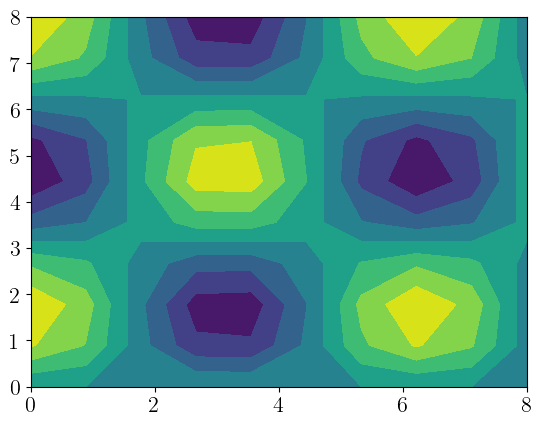

In [29]:
plt.contourf(x_m[:,:,0], y_m[:,:,0], n_m[:,:,0])
plt.show()

In [30]:
def torch_interpolate(array, shape):
    n_torch = torch.tensor(array[None, None, ...])
    tmp = torch.nn.functional.interpolate(n_torch, shape)
    return tmp[0,0,...]
n_sampled = torch_interpolate(n_m, n_m.shape)

r = np.array([x_s[1], y_s[2], z_s[0]])
r

array([0.88888889, 1.77777778, 0.        ])

In [ ]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

# interp = LinearNDInterpolator(list(zip(x_m.ravel(), y_m.ravel(), z_m.ravel())), n_m.ravel())
interp = NearestNDInterpolator(list(zip(x_m.ravel(), y_m.ravel(), z_m.ravel())), n_m.ravel())
interp_test = interp(x_m, y_m, z_m)

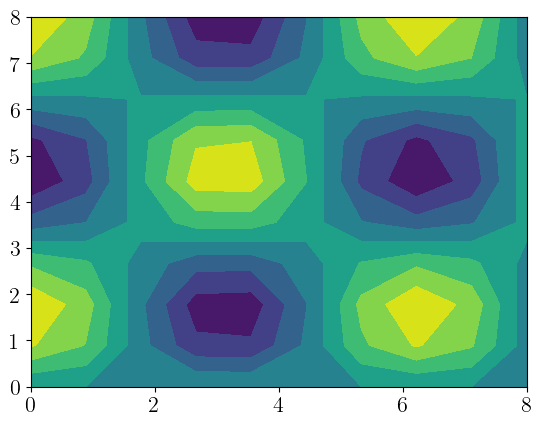

In [34]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator, CloughTocher2DInterpolator, RBFInterpolator

# interp = LinearNDInterpolator(list(zip(x_m.ravel(), y_m.ravel(), z_m.ravel())), n_m.ravel())
interp = NearestNDInterpolator(list(zip(x_m.ravel(), y_m.ravel(), z_m.ravel())), n_m.ravel())
# interp = CloughTocher2DInterpolator(list(zip(x_m[...,0].ravel(), y_m[...,0].ravel())), n_m[...,0].ravel())
# plt.pcolormesh(x_m, y_m, interp(x_m, y_m, z_m))
# interp_test = interp(x_m[...,0], y_m[...,0])
# plt.contourf(x_m[...,0], y_m[...,0], interp_test)
interp_test = interp(x_m, y_m, z_m)
plt.contourf(x_m[...,0], y_m[...,0], interp_test[...,0])
plt.show()

In [ ]:
# def n_e_sampled(r):
#     return ...

# def omega_p_squared(r):
#     return n_e_sampled(r) * e**2 / (eps_0 * m_e)

torch.Size([1, 1, 10, 10, 1])